In [6]:
import numpy as np                      
import itertools                       
import seaborn as sns                    
import matplotlib.pyplot as plt          
import random                            
from datetime import datetime as dt      
from typing import Callable, List, Tuple, Dict


DEBUG = True

# Debugging function
def debugger_factory(show_args=True) -> Callable:
    """
    This function creates a debugging wrapper for functions.
    """
    def debugger(func: Callable) -> Callable:
        if DEBUG:   
            def wrapper(*args, **kwargs):
                if show_args:
                    print(f'{func.__name__} was called')  
                t0 = dt.now()                              
                results = func(*args, **kwargs)            
                print(f'{func.__name__} ran for {dt.now()-t0}')  
                return results                             
        else:
            return func                                    
        return wrapper
    return debugger

In [7]:
# We are using half the size of a full deck
HALF_DECK_SIZE = 26


def get_init_deck(half_deck_size: int) -> np.ndarray:
    """
    This function creates an initial decks of 0s (Blacks) and 1s (Reds)
    
    """
    return np.array([0] * half_deck_size + [1] * half_deck_size)

def shuffle_deck(seed: int, deck: np.ndarray) -> np.ndarray:
    """
    This function shuffles a deck using a specific random seed. Shuffles a given deck using a specified seed.
    
    """
    np.random.seed(seed)             # Allows us to store a random seed
    shuffled_deck = deck.copy()      # Making a copy of the deck
    np.random.shuffle(shuffled_deck) # Allows us to shuffle the deck
    return shuffled_deck             # Returns the shuffled deck


@debugger_factory()
def get_n_decks(num_decks: int, num_cards: int = HALF_DECK_SIZE) -> List[Tuple[int, np.ndarray]]:
    """
    This function creates a list of shuffled decks each with unique random seeds. Also, each deck has a tuple containing (seed, deck).
    """
    init_deck = get_init_deck(num_cards)  # This creates the initial deck
    decks = []                            # This creates a list to store the decks

    for _ in range(num_decks):
        seed = random.randint(0, 2**31 - 1)          # This generates a random seed from 0 to 2,147,483,648
        shuffled_deck = shuffle_deck(seed, init_deck) # This shuffles the deck using that assigned random seed
        decks.append((seed, shuffled_deck))           # This stores the seeds and the shuffled decks

    return decks


In [8]:
def generate_sequences() -> List[Tuple[int, int, int]]:
    """This function creates all possible combinations of 0s and 1s Generates all possible three-card sequences of 0s and 1s."""
    return list(itertools.product([0, 1], repeat=3))  # This creates all possible combinations of 3-bit sequences 3-bit binary sequence

def generate_1_game(deck: np.ndarray, player1_seq: Tuple[int, int, int], player2_seq: Tuple[int, int, int]) -> Tuple[int, int, int, int]:
    """
    This function plays one game. Each player chooses a sequence. And the player whose sequence appears first in the deck is the winner.
    """
    if player1_seq == player2_seq:
        raise ValueError("Players cannot choose the same sequence.") # This ensures that both players cannot choose the same sequence

    # These two lines convert the deck and sequences into strings so that we can easily search within them.
    deck_str = ''.join(map(str, deck)) 
    p1_str, p2_str = ''.join(map(str, player1_seq)), ''.join(map(str, player2_seq))

    # These two lines count how many times each player's desired sequence shows up in the deck (tricks).
    p1_count = deck_str.count(p1_str)
    p2_count = deck_str.count(p2_str)

    # These two lines counts the total amount of cards used for each player's desired sequence (totals cards)
    p1_total_cards = sum(len(p1_str) for i in range(len(deck) - 2) if deck_str[i:i+3] == p1_str)
    p2_total_cards = sum(len(p2_str) for i in range(len(deck) - 2) if deck_str[i:i+3] == p2_str)

    return p1_count, p2_count, p1_total_cards, p2_total_cards


@debugger_factory()
def simulate_games(num_decks: int = 100000) -> Tuple[Dict[Tuple, Dict[str, float]], Dict[Tuple, List[int]]]:
    """
    This function simulates all games for each deck in num_decks. It also calculates win percentages and draw percentages.
    """
    sequences = generate_sequences()    # Creates all 3-bit sequences
    results = {}                        # Stores win and draw probabilities
    seeds = {}                          # Stores each deck's seed

    # This loop will help us iterate over all possible pairs of sequences (56 possible combinations).
    for player1_seq, player2_seq in itertools.combinations(sequences, 2):
        decks = get_n_decks(num_decks)  # This allows us to get the shuffled decks

        # These four lines will help us keep track of the tricks, total cards, and draws
        p1_wins_trick, p2_wins_trick = 0, 0
        p1_wins_total, p2_wins_total = 0, 0
        draws1 = 0
        draws2 = 0

        # This loop plays all each deck
        for seed, deck in decks:
            p1_count, p2_count, p1_cards, p2_cards = generate_1_game(deck, player1_seq, player2_seq)

            # These five linese determine the winner based on the number of tricks
            if p1_count > p2_count:
                p1_wins_trick += 1
            elif p2_count > p1_count:
                p2_wins_trick += 1
            else:
                draws1 += 1

            # These four lines determine the winner by comparing the total amount of cards used by each player
            if p1_cards > p2_cards:
                p1_wins_total += 1
            elif p2_cards > p1_cards:
                p2_wins_total += 1
            else:
                draws2 += 1

        # These two blocks of code help us store our probabilities.
        results[(player1_seq, player2_seq)] = {
            "Player 2 Win % (Trick)": p2_wins_trick / num_decks,
            "Player 2 Win % (Total)": p2_wins_total / num_decks,
            "Draw %": draws1 / num_decks
        }
        results[(player2_seq, player1_seq)] = {
            "Player 2 Win % (Trick)": p1_wins_trick / num_decks,
            "Player 2 Win % (Total)": p1_wins_total / num_decks,
            "Draw %": draws2 / num_decks
        }

    return results, seeds


In [9]:

@debugger_factory()  
def visualize_heatmap(results: Dict[Tuple, Dict[str, float]], metrics: List[str]):
    """
    This function displays two heatmaps of player 2's win probabilites and draws. The left heatmap is based on using tricks, and the 
    right heatmap is based on using total cards. 
    """
    # This will create all possible sequences
    sequences = generate_sequences()

    # This will tell us how many heatmaps we need to create.
    num_metrics = len(metrics)

    # Set up the figure with subplots, one for each metric
    fig, axes = plt.subplots(1, num_metrics, figsize=(8 * num_metrics, 8))

    # If there's only one metric, make sure axes is a list (for consistent handling later)
    if num_metrics == 1:
        axes = [axes]

    # Convert sequences into a more readable label format
    # e.g., (0,0,1) becomes 'BBR' (B for 0, R for 1)
    formatted_labels = [''.join(['B' if x == 0 else 'R' for x in seq]) for seq in sequences]

    # Loop over each requested metric (one heatmap per metric)
    for idx, metric in enumerate(metrics):
        # This will create an empty square matrix
        matrix = np.zeros((len(sequences), len(sequences)))

        # This will create an annotation matrix that will hols the text labels in each heatmap cell.
        annotations = np.empty((len(sequences), len(sequences)), dtype=object)

        # This loop will fill the matrix and annotations with the probability data
        for (p1_seq, p2_seq), stats in results.items():
            # This will find the index for each sequence.
            i, j = sequences.index(p1_seq), sequences.index(p2_seq)

            # These two lines will get the value for the current metric such as win percentage
            win_pct = int(stats.get(metric, 0) * 100)  # This line converts the win decimal into a percentage
            draw_pct = int(stats.get("Draw %", 0) * 100)  # This line converts the draw decimal to a percentage

            # This will set the annotation for each cell, which is something like "65% (5%)". The draw percentage is in the parenthesis, and the other value is the win percentage
            annotations[i, j] = f"{win_pct}% ({draw_pct}%)"

            # This will set the matrix value
            matrix[i, j] = win_pct

        # This will create a heatmap using seaborn
        sns.heatmap(
            matrix,                                
            annot=annotations,                     
            fmt="",                                
            xticklabels=formatted_labels,          
            yticklabels=formatted_labels,          
            cmap="coolwarm",                       
            linewidths=0.5,                        
            annot_kws={"size": 9},                 
            ax=axes[idx]                           
        )
        axes[idx].set_title(f"Heatmap of {metric}", fontsize=14) # This sets the title of each heatmap
        axes[idx].set_xlabel("Player 2 Choices", fontsize=12) # This sets the label for the x-axis
        axes[idx].set_ylabel("Player 1 Choices", fontsize=12) # This sets the label for the y-axis

        # These two lines of code rotate the labels for better redability
        plt.setp(axes[idx].get_xticklabels(), rotation=45, ha="right")
        plt.setp(axes[idx].get_yticklabels(), rotation=0)

    # This line adjusts the layout so that the plots don't overlap with each other   
    plt.tight_layout()

    # This will show all heat maps
    plt.show()



simulate_games was called
get_n_decks was called
get_n_decks ran for 0:00:01.016361
get_n_decks was called
get_n_decks ran for 0:00:00.992718
get_n_decks was called
get_n_decks ran for 0:00:00.963658
get_n_decks was called
get_n_decks ran for 0:00:01.047022
get_n_decks was called
get_n_decks ran for 0:00:01.007641
get_n_decks was called
get_n_decks ran for 0:00:00.951151
get_n_decks was called
get_n_decks ran for 0:00:00.954177
get_n_decks was called
get_n_decks ran for 0:00:00.977290
get_n_decks was called
get_n_decks ran for 0:00:00.958437
get_n_decks was called
get_n_decks ran for 0:00:00.954202
get_n_decks was called
get_n_decks ran for 0:00:00.950252
get_n_decks was called
get_n_decks ran for 0:00:00.949446
get_n_decks was called
get_n_decks ran for 0:00:00.952199
get_n_decks was called
get_n_decks ran for 0:00:00.960032
get_n_decks was called
get_n_decks ran for 0:00:00.980826
get_n_decks was called
get_n_decks ran for 0:00:00.948283
get_n_decks was called
get_n_decks ran for 0:0

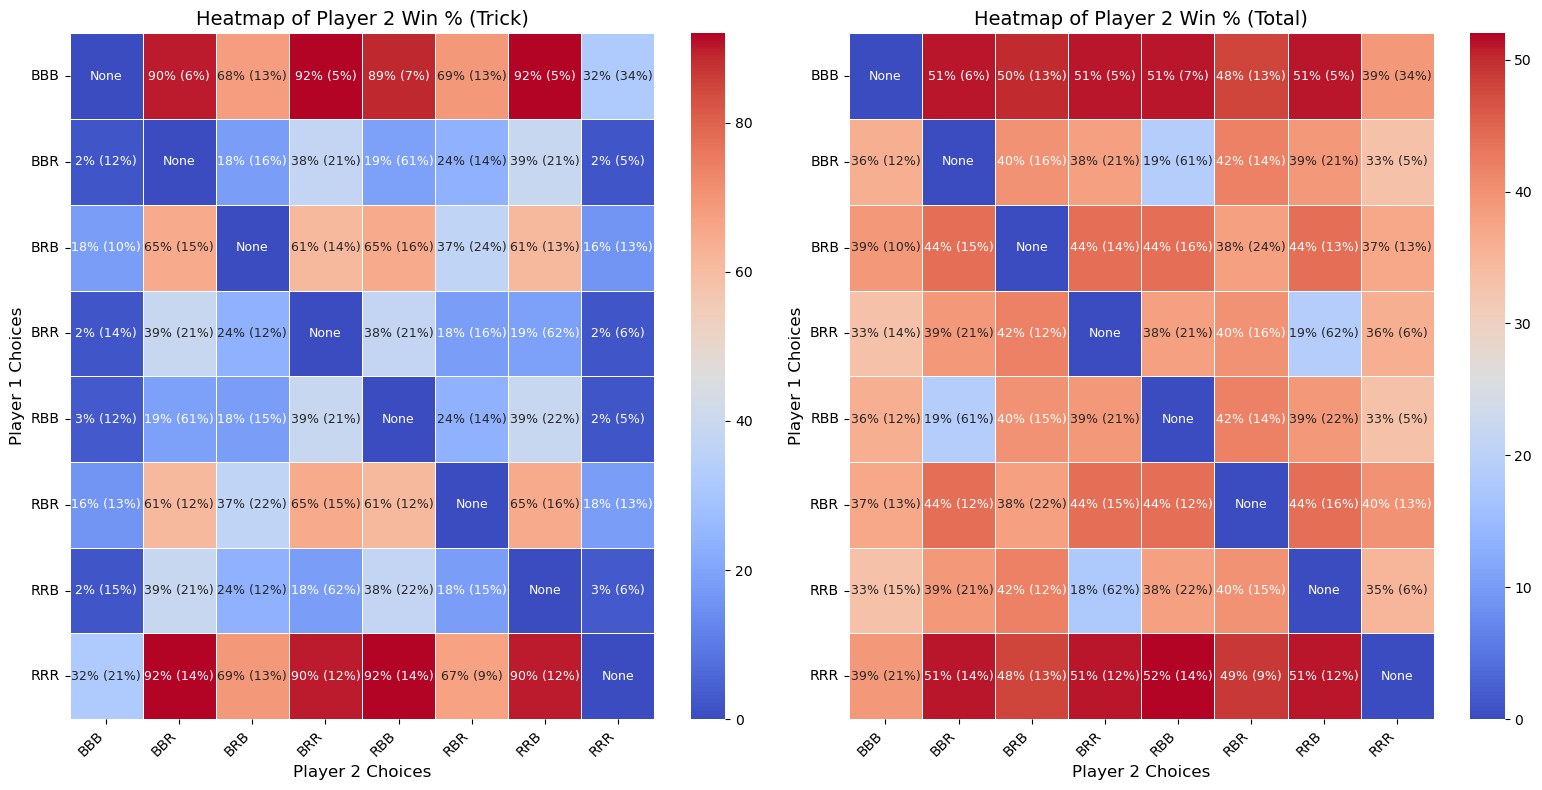

visualize_heatmap ran for 0:00:00.957899


In [10]:
# This will simulate 100000 games of penney
num_decks_to_generate = 100000
results, seeds = simulate_games(num_decks_to_generate)

# This will visualize our results with heatmaps
visualize_heatmap(results, ["Player 2 Win % (Trick)", "Player 2 Win % (Total)"])
